# Kili Tutorial : reading and uploading dicom image data to Kili Technology

In this tutorial, we will show you how to upload medical images to Kili Technology. We will use [pydicom](https://pydicom.github.io/pydicom/stable/), a python package, to read medical data.

Data used in this tutorial comes from the [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data) hosted on Kaggle in 2018.

In [1]:
# Import packages
!pip install pydicom
import os
import glob
from collections import defaultdict
import pickle


import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches
from PIL import Image
import numpy as np
import pandas as pd

In [2]:
data_folder = "./datasets"
files = glob.glob(f'{data_folder}/*.dcm')
files

['./datasets/0005d3cc-3c3f-40b9-93c3-46231c3eb813.dcm',
 './datasets/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm']

In [3]:
# Extract metadata and generate jpeg from the dicom image field.
# You should then upload your generated jpegs.
def dcm2metadata(sample):
    metadata = {}
    for key in sample.keys():
        if key.group < 50:
            item = sample.get(key)
            if hasattr(item, 'description') and hasattr(item, 'value'):
                metadata[item.description()] = str(item.value)
    return metadata

processed_imgs = []
metadata_array = []
for file in files:
    fname = file.split('/')[-1].split('.')[0]
    sample = pydicom.dcmread(file)
    im = Image.fromarray(sample.pixel_array)
    fpath = f'{data_folder}/{fname}.jpeg'
    im.save(fpath)
    processed_imgs.append(fpath)
    metadata_array.append(dcm2metadata(sample))

In [4]:
# Connect to kili
# !pip install kili # uncomment if you don't have kili installed already
from kili.authentication import KiliAuth
from kili.playground import Playground

email = os.getenv('KILI_USER_EMAIL')
password = os.getenv('KILI_USER_PASSWORD')
api_endpoint = os.getenv('KILI_API_ENDPOINT') # If you use Kili SaaS, use 'https://cloud.kili-technology.com/api/label/graphql'

kauth = KiliAuth(email=email, password=password, api_endpoint=api_endpoint)
playground = Playground(kauth)

/Users/maximeduval/Documents/kili-playground/kili/authentication.py:50: UserWarning: Kili Playground version should match with Kili API version.
Please install version: "pip install kili==2.0.1"
  warnings.warn(message, UserWarning)


In [5]:
# Create and define the annotation interface. You can also refine it in the app.
# JSON interface
job_id = 'JOB_0'
json_interface = {
  "filetype": "IMAGE",
	"jobs": {
		"CLASSIFICATION_JOB": {
			"mlTask": "CLASSIFICATION",
			"content": {
				"categories": {
					"YES": {
						"name": "Yes"
					},
					"NO": {
						"name": "No"
					}
				},
				"input": "radio"
			},
			"required": 1,
			"isChild": False,
			"instruction": "Healthy ?"
		},
		"JOB_0": {
			"mlTask": "OBJECT_DETECTION",
			"content": {
				"categories": {
					"BONE": {
						"name": "bone"
					},
					"TISSUE": {
						"name": "tissue"
					},
					"LUNG": {
						"name": "lung"
					},
					"RIB": {
						"name": "rib"
					}
				},
				"input": "radio"
			},
			"required": True,
			"tools": [
				"semantic"
			],
			"instruction": "Segmentation"
		}
	}
}       

In [6]:
# Create the project
title = 'Medical Imaging with Kili Technology'
description = 'This is a test project'
input_type = 'IMAGE'

project = playground.create_empty_project(user_id=playground.auth.user_id)
project_id = project['id']
playground.update_properties_in_project(project_id=project_id,
                                        title=title,
                                        description=description,
                                        input_type=input_type,
                                        json_interface=json_interface)

{'id': 'cka3njik94ria07667xj8hy7x'}

In [7]:
# Upload your files to the project.
# We uploaded the previous jpegs to google drive.
content_array = ['https://drive.google.com/uc?id=18tEnN9lsKlp1tcd0WnfknZJq7d5v5Tod',
                 'https://drive.google.com/uc?id=1jvt_LzZAvSr8wyRiwlibXdEszVvyQxjK']
external_id_array = ['01',
                     '02']
playground.append_many_to_dataset(project_id=project_id,
                                  content_array=content_array,
                                  external_id_array=external_id_array,
                                  json_metadata_array=metadata_array)

{'id': 'cka3njik94ria07667xj8hy7x'}

You can then annotate the image in kili : ![alt text](./img/kili-annot.png)

In [8]:
# Once annotated, you can import the labels
labeled_assets = playground.assets(project_id=project_id, external_id_contains=['01'])
if 'labels' in labeled_assets[0].keys():
    labels = labeled_assets[0]['labels'][0]['jsonResponse']
else:
    with open('./conf/medical-labels.pkl', 'rb') as f:
        labels = pickle.load(f)
with open('./conf/medical-labels.pkl', 'wb') as f:
    pickle.dump(labels, f)
healthy = labels['CLASSIFICATION_JOB']['categories'][0]['name']
semantic = labels['JOB_0']['annotations']

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


In [9]:
# Extract labels
points = pd.DataFrame(semantic[0]['boundingPoly'][0]['normalizedVertices']).values
def transform2image(points, shape):
    newpoints = np.zeros(points.shape)
    newpoints[:, 0] = points[:, 0] * shape[0]
    newpoints[:, 1] = points[:, 1] * shape[1]
    return newpoints

category2points = defaultdict(list)
for annotation in semantic:
    category = annotation['categories'][0]['name']
    points = pd.DataFrame(annotation['boundingPoly'][0]['normalizedVertices']).values
    category2points[category].append(points)
    
fname = files[0].split('/')[-1].split('.')[0]
im = Image.open(f'{data_folder}/{fname}.jpeg')

Text(0.5, 1.0, 'Healthy : YES')

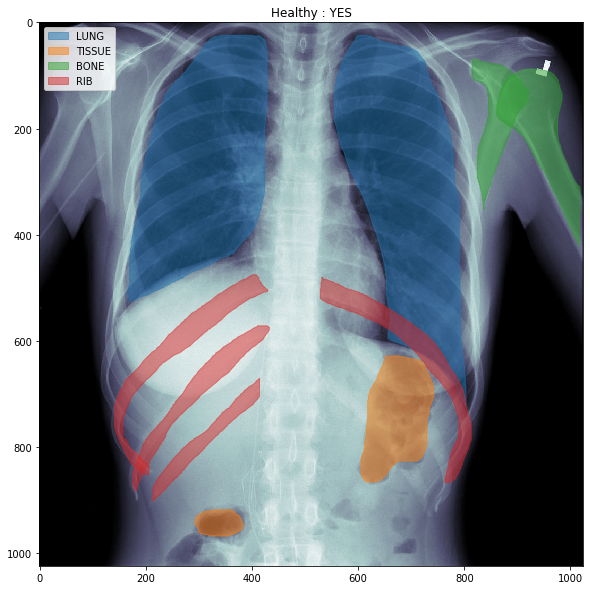

In [11]:
# Plot the labels
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im, cmap=plt.cm.bone)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, (category, shapes) in enumerate(category2points.items()):
    for j, shape in enumerate(shapes):
        if j == 0:
            poly = matplotlib.patches.Polygon(transform2image(shape, im.size),
                                              color=colors[i], alpha=0.5, label=category)
        else:
            poly = matplotlib.patches.Polygon(transform2image(shape, im.size),
                                              color=colors[i], alpha=0.5)
        ax.add_patch(poly)
ax.legend()
ax.set_title(f'Healthy : {healthy}')